# Pipeline Example

In [17]:
import BalloonModelLib as bml
import matplotlib.pyplot as plt 
import numpy as np 

Below is a step-by-step demonstration of the BalloonModelLib library, following the construction outlined by Maith 2022 in his paper "Modeling the hemodynamic response to brain activation."

Let's recall:
   - We are usin Maith 2022 Pipeline seen in the following figure.
   - The resolution of the differential equations is achieved using **odeint**.
   - Array_extend extends the temporal resolution of an array by a factor of dt. For example, array_extend([0,0,1], dt=0.5)=[0,0,0,0,1,1].


![ALT_TEXT_FOR_SCREEN_READERS](./Img/PipelineMaith2022.png)

## Neuro-Vascular Coupling

We can calculate the normalised inflow (CBF) or cerebral oxygen metabolic rate ($CMRO_2$) as a linear relationship where the vascular response to neural activity corresponds to a damped oscillator: changes in neural activity $I(t)$ generate a vasodilatory signal that decays exponentially, $s(t)$, which is also subject to regulation through feedback by the inducing blood flow/ metabolic rate of $O_2 (f_{in}(t), m(t))$.

\begin{equation*}
\begin{split}
\frac{ds}{dt} &= \lambda_r \cdot I(t)-\kappa \cdot s(t)- \gamma \cdot (r(t)-1)\\
\frac{r}{dt} &= s(t)    
\end{split}
\end{equation*}

con:

- $\lambda_r \begin{cases}  0.2 \quad &if \quad r=f_{in}\\  0.05 \quad &if \quad r=m\end{cases}$
- $\kappa = 1/1.54$  
- $\gamma = 1/2.46$  


tha function called NeurovascularCoupling computes both $s$ and $r$ so, when invoked, keep it mind 

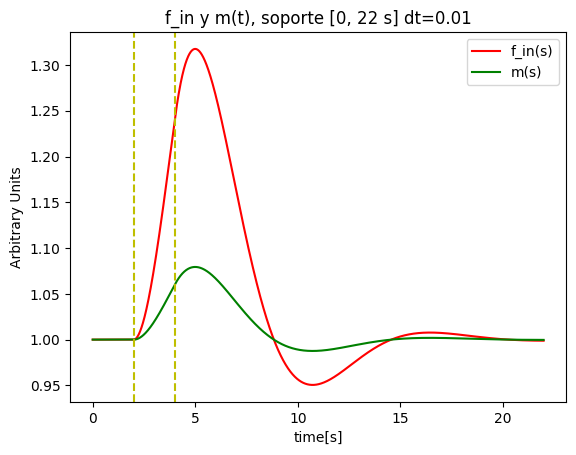

In [18]:
# Stimuli and Neural Response 
stim=[ 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dt_exm=0.01

#CBF Response function parameters
f_parameters = {'gamma': 1/2.46 , 'kappa':1/1.54}

f, _ = bml.NeurovascularCoupling(stimulus=stim, version='differential', params=f_parameters,  AmpI=0.2)  #AmpI = lambda_r
m, _ = bml.NeurovascularCoupling(stim, AmpI=0.05 )  #AmpI = lambda_r
time= np.arange(0,len(f)*dt_exm, dt_exm)

plt.plot(time, f, label='f_in(s)', color='red')
plt.plot(time, m, label='m(s)', color='green')
plt.axvline(x =2, color = 'y', ls='--')
plt.axvline(x =4, color = 'y', ls='--')

plt.title('f_in y m(t), soporte [0, %d s] dt=0.01' %np.round(len(f)*dt_exm))
plt.xlabel('time[s]')
plt.ylabel('Arbitrary Units')
plt.legend()

plt.show()


The vertical line at 2 and 4 seconds represents the stimulus start and ending. It is clear that in the signal $m(t)$, there is no delay between blood flow and oxygen metabolism, which is biophysically counterintuitive; For the calculations made by Friston 2000 and Maith 2022, there is no natural way to induce the delay shown by Buxton 2004, but they naturally integrate an undershoot around 10 seconds.

## The Core of the Balloon Model

We now have the necessary elements, namely $f_{in}(t)$ and $m(t)$, for the Balloon model. The Balloon model consists of 2 equations ($\frac{dq}{dt}$, $\frac{dv}{dt}$) as presented in equation 10 of Buxton 2004 but requires a third equation, Buxton's equation 11, $f_{out}(t)$.

\begin{equation*}
\begin{split}
    f_{out}(t) &= v(t)^{\frac{1}{\alpha}} + \tau_{m} \frac{dv}{dt}\\ 
    \frac{dv}{dt} &= \frac{1}{\tau_{MTT}} \cdot [f_{in}(t)-f_{out}(t)] \\
    \frac{dq}{dt} &= \frac{1}{\tau_{MTT}} \cdot [m(t)- \frac{q(t)}{v(t)}\cdot f_{out}(t)]
\end{split}
\end{equation*}

Where $\tau_{MTT}=3.0 s$ is the mean transit time through the balloon, while the viscoelastic time constant $\tau_{m}=20 s$, $\alpha=0.4$.

The solution for the system of equations, as a whole.

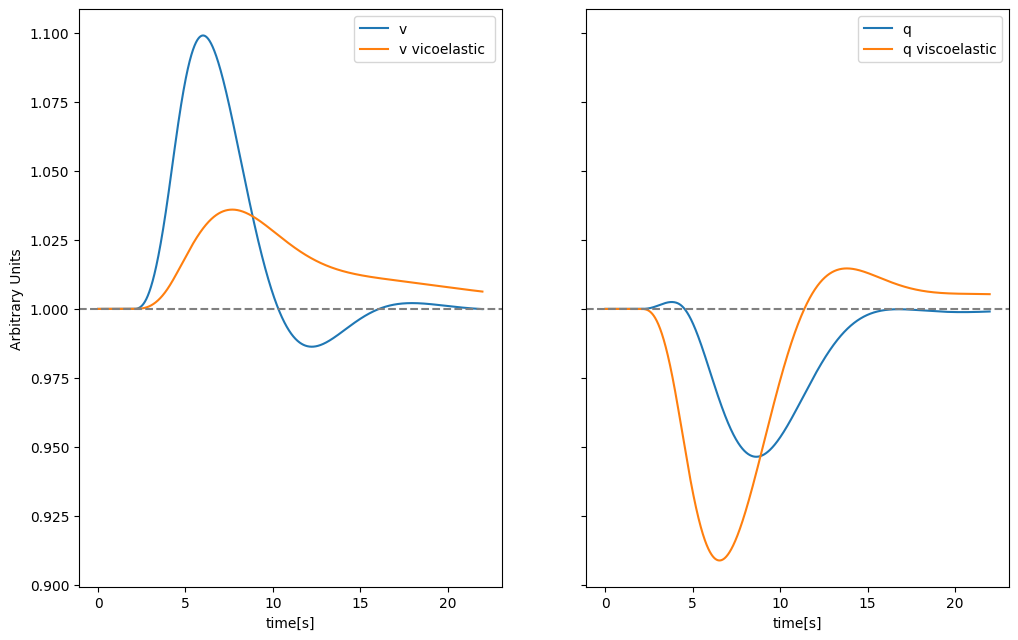

In [19]:
vol_q_parameters= {'tau_MTT':3.0, 'alpha':0.4, 'tau_m':20}
v, q= bml.Balloon_odeint(f, m, params=vol_q_parameters, viscoelastic=False)
v_v, q_v= bml.Balloon_odeint(f, m, params=vol_q_parameters, viscoelastic=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 7.5))

axs[0].plot(time, v , label='v', linestyle='-')
axs[0].plot(time, v_v , label='v vicoelastic ')
axs[0].axhline(y =1, color = 'gray', ls='--')
axs[0].set_ylabel('Arbitrary Units')
axs[0].set_xlabel('time[s]')
axs[0].legend()

axs[1].plot(time, q , label='q ', linestyle='-')
axs[1].plot(time, q_v , label='q viscoelastic')
axs[1].axhline(y =1, color = 'gray', ls='--')
axs[1].set_xlabel('time[s]')


plt.legend()
plt.show()


## BOLD Signal 

Finally, we are in a position to calculate the Bold signal. It is worth noting that, as with $m(t)$, there are at least 2 ways to calculate it. Following Stphen 2007 we stay with the non linear combination of $v$ and $q$ while implementing the variations on the coefficients. Additionally we plot the trajectory of our balloon model $q(t)$ _vs_ $v(t)$.

\begin{equation}
    BOLD(v,q)= V_0 \cdot \left( k_1 \cdot [1.0-q(t)] + k_2\cdot[1.0 - \frac{q(t)}{v(t)}] + k_3 \cdot [1.0 - v(t)]\right)
    
\end{equation}


\begin{align}
    &Revisted &  &Classic \\
    k_1 &= 4.3V_0\vartheta_0E_0T_E & k_1 &= (1-4.3)V_0\vartheta_0E_0T_E \\
    k_2 &= \epsilon r_0E_0T_E& k_2 &= 2 E_0\\
    k_3 &=1-\epsilon     & k_3 &=1-\epsilon
\end{align}

where we use values described in  Stephan 2007, Maith 2022 for a field strength of $1.5 T$, 
- $V_0(0.03) =$ Baseline blood volume;
- $\vartheta_0(40.3 s^{-1})=$ The frequency offset at the outer surface of the magnetized vessel for fully deoxygenated blood;
- $E_0(0.4) =$ Baseline $O_2$ extraction fraction; 
- $T_E=$ Echo time;
- $\epsilon(1.43)=$ the ratio of intra- and extravascular signal;
- $r_0(25 s^{-1})=$ The slope of the relation between the intravascular relaxation rate and oxygen saturation;





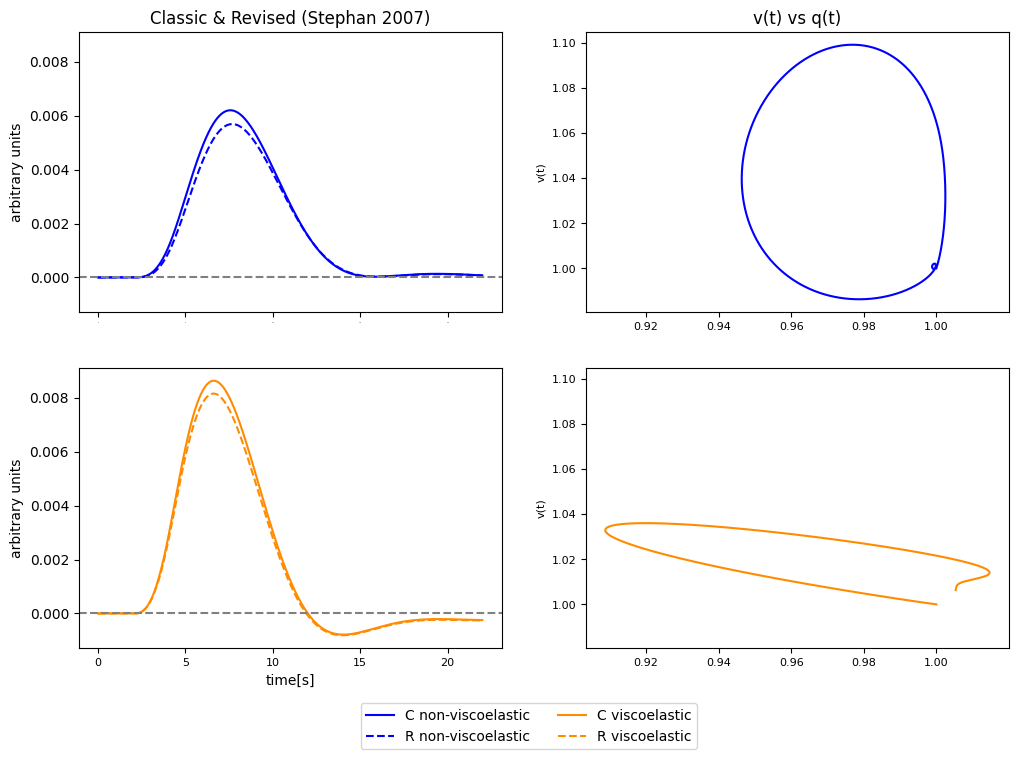

In [20]:
bold_params={'V_0':0.03, 'O_o': 40.3, 'E_0':0.32, 'TE' : 0.04 ,'eps': 1.43 ,'r_0': 25} 

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(time, bml.BOLD_func(v,q, params=bold_params, BM='classic'), color='b', label='C non-viscoelastic' )
ax1.plot(time, bml.BOLD_func(v,q, params=bold_params, BM='revised'), color='b', label='R non-viscoelastic', linestyle='--')
ax1.axhline(y =0, color = 'gray', ls='--')
ax1.set_ylabel('arbitrary units')
ax1.set_title('Classic & Revised (Stephan 2007)')
ax1.tick_params(axis='x', which='major', labelsize=0)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_ylabel('v(t)', fontsize=8)
ax2.plot(q, v, color='b')
ax2.set_title('v(t) vs q(t)')
ax2.tick_params(axis='both', which='major', labelsize=8)

ax3 = fig.add_subplot(2, 2, 3, sharex = ax1, sharey = ax1)
ax3.set_ylabel('arbitrary units')
ax3.set_xlabel('time[s]')
ax3.plot(time, bml.BOLD_func(v_v, q_v, params=bold_params, BM='classic'), color='darkorange', label='C viscoelastic')
ax3.plot(time, bml.BOLD_func(v_v, q_v, params=bold_params, BM='revised'), color='darkorange', label='R viscoelastic', linestyle='--')
ax3.axhline(y =0, color = 'gray', ls='--')
ax3.tick_params(axis='x', which='major', labelsize=8)

ax4 = fig.add_subplot(2, 2, 4, sharex = ax2, sharey = ax2)
ax4.set_ylabel('v(t)', fontsize=8)
ax4.plot(q_v, v_v, color='darkorange')
ax4.tick_params(axis='both', which='major', labelsize=8)


fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)
# plt.savefig('.\img\BOLDs_en_event.png')

plt.show()

Additionally, there is a third way to calculate the BOLD signal, i.e., following Davis et al. (1998),

$$\frac{\Delta S}{S_0}= A\cdot (1-f^{\alpha-\beta}m^{\beta})$$

In Buxton 2004, numerical simulations and theoretical analyses suggest that when diffusion is not significant, $\beta=1$, but $\beta = 2$ provides a better description of smaller vessels where diffusion effects are important. Numerical simulations for a mixture of vessel sizes suggest that $\beta = 1.5$ is a good approximation for 1.5–3 T, but at higher fields, $\beta$ should approach 1. The essential problem when applying this equation to measured data is the uncertainty about the value of A. In simple terms, A is the maximum BOLD signal change that could occur, corresponding to complete removal of deoxyhemoglobin from the voxel; the parameter A is a local parameter and can therefore vary between different voxels in the brain. 
$$A \in [0.075,0.079]\\
\alpha = 0.4\\
 \beta= 1.5$$

while Maith 2022 tells us that:
$$A=14.9\\
\alpha = 0.14\\
\beta= 0.91$$

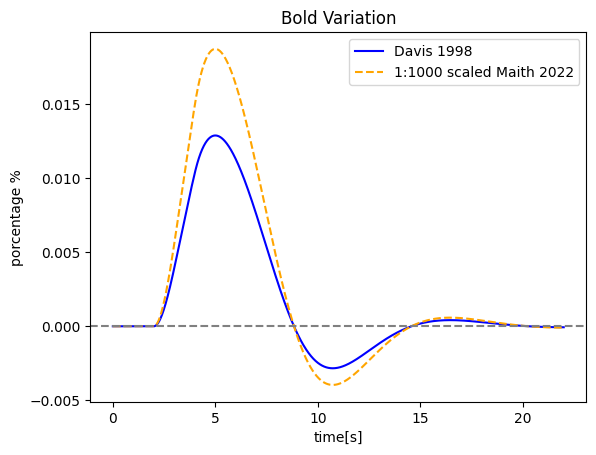

In [21]:
plt.plot(time,bml.BOLD_Davis(f,m,author='Davis1998'), label='Davis 1998', color='b', linestyle='-')
plt.plot(time,bml.BOLD_Davis(f,m,author='Maith2022')/1000, label='1:1000 scaled Maith 2022', color='orange', linestyle='dashed')
plt.axhline(y =0, color = 'gray', ls='--')

plt.title('Bold Variation')
plt.xlabel('time[s]')
plt.ylabel('porcentage %')
plt.legend()

# plt.savefig('BOLDDavis_en.png')
plt.show()